# 確率ロボティクス課題

## 参考
+ [詳解 確率ロボティクス](https://www.amazon.co.jp/%E8%A9%B3%E8%A7%A3-%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9-Python%E3%81%AB%E3%82%88%E3%82%8B%E5%9F%BA%E7%A4%8E%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%AE%E5%AE%9F%E8%A3%85-KS%E7%90%86%E5%B7%A5%E5%AD%A6%E5%B0%82%E9%96%80%E6%9B%B8-%E4%B8%8A%E7%94%B0/dp/4065170060/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&dchild=1&keywords=%E8%A9%B3%E8%A7%A3+%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9&qid=1610537879&sr=8-1)
+ [詳解 確率ロボティクスのサンプルコード](https://github.com/ryuichiueda/LNPR_BOOK_CODES)
+ [確率ロボティクス](https://www.amazon.co.jp/%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9-%E3%83%97%E3%83%AC%E3%83%9F%E3%82%A2%E3%83%A0%E3%83%96%E3%83%83%E3%82%AF%E3%82%B9%E7%89%88-Sebastian-Thrun/dp/4839952981/ref=sr_1_2?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&dchild=1&keywords=%E8%A9%B3%E8%A7%A3+%E7%A2%BA%E7%8E%87%E3%83%AD%E3%83%9C%E3%83%86%E3%82%A3%E3%82%AF%E3%82%B9&qid=1610537879&sr=8-2)

## 問題設定
+ ロボットはx,y方向に移動可能→状態方程式は線形
+ 回転はしない
+ 観測はロボットから見たランドマークの相対位置→観測方程式は非線形
+ 観測はロボットとランドマークの距離が0.5~4[m]の範囲で有効
+ 移動は約5[m]移動ごとにxyそれぞれに約0.05[m]の誤差が発生
+ 観測は約0.1[m]の誤差が発生

In [1]:
%matplotlib nbagg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm

import math
import numpy as np
from scipy.stats import expon, norm, multivariate_normal
from matplotlib.patches import Ellipse

In [2]:
class World:
    '''
    シミュレーション全体の管理
    '''
    def __init__(self, time_span, time_interval, debug=False): #シミュレーション時間, シミュレーション更新周期
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
    
    def append(self, obj):
        self.objects.append(obj)
    
    def draw(self):
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        ax.set_aspect("equal")
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        
        elems = []
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
        plt.show()
    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t=%.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)

In [3]:
class MyRobot:
    '''
    ロボット1台の処理関係
    agentとsensorを含む
    '''
    def __init__(self, pose, agent=None, sensor=None, color="red"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose] #移動の軌跡を保存
        self.sensor = sensor
        
    def draw(self, ax, elems):
       
        #初期値or状態遷移後のposeを取得
        x,y = self.pose
        robot = patches.Circle(xy=(x,y), radius=self.r, color=self.color)
        elems.append(ax.add_patch(robot))
        
        self.poses.append(np.array([x,y]).T)
        poses_x = [e[0] for e in self.poses]
        poses_y = [e[1] for e in self.poses]
        elems += ax.plot(poses_x, poses_y, linewidth=0.5, color="black")
        
        if self.sensor and len(self.poses) > 1:
            #状態遷移前の姿勢で観測しているのでposes[-2] (一つ前の姿勢値から線分の計算)
            self.sensor.draw(ax, elems, self.poses[-2])
        
        if self.agent and hasattr(self.agent, "draw"):
            self.agent.draw(ax, elems)
    
    @classmethod
    def state_transition(cls, v_x, v_y, time, pose): #x軸の速度, y軸の速度, 移動時間
        return pose + np.array([v_x*time, v_y*time])
    
    def one_step(self, time_interval):
        if self.agent:
            #観測
            obs = self.sensor.data(self.pose) if self.sensor else None
            # >>> 現在の姿勢と観測結果がわかった状態
            
            #エージェントによる制御値の決定
            v_x, v_y = self.agent.decision(obs)
            
            #状態遷移
            self.state_transition(v_x, v_y, time_interval)
            # >>> 現在の姿勢が更新, 観測はまだ

In [4]:
class Agent:
    '''
    ロボットの動作を決定する, agent(操縦者)としてRobotに登録する
    '''
    def __init__(self, v_x, v_y):
        self.v_x = v_x
        self.v_y = v_y
        self.counter =0
    
    def decision(self, observation=None):
        self.counter += 1
        return self.v_x, self.v_y

In [5]:
class Landmark:
    '''
    観測地点のデータ, Mapに登録する
    '''
    def __init__(self, x, y):
        self.pos=np.array([x,y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))

In [6]:
class Map:
    '''
    Landmarkを管理する
    '''
    def __init__(self):
        self.landmarks = []
        
    def append_landmark(self, landmark):
        landmark.id = len(self.landmarks)
        self.landmarks.append(landmark)
    
    def draw(self, ax, elems):
        for lm in self.landmarks:
            lm.draw(ax, elems)

In [9]:
class MyCamera:
    '''
    観測を管理する, sensorとしてRobotに登録する
    '''
    def __init__(self, env_map, distance_range = (0.5, 4)):
        self.map = env_map
        self.lastdata = []
        self.distance_range = distance_range
    
    def visible(self, pos):
        if pos is None:
            return False
        
        distance = np.hypot(*pos)
        return self.distance_range[0] <= distance <= self.distance_range[1]
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
        
        self.lastdata = observed
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose
        return np.array(diff).T
    
    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y = cam_pose
            lx = lm[0][0] + x
            ly = lm[0][1] + y
            elems += ax.plot([x,lx],[y,ly], color="pink")

In [10]:
class Robot(MyRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black", noise_per_meter=5, noise_std=0.05):
        super().__init__(pose, agent, sensor, color)
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        self.distance_until_noise = self.noise_pdf.rvs()
        self.pose_noise = norm(scale=noise_std)
    
    def noise(self, pose, v_x, v_y, time_interval):
        distance = np.hypot(v_x*time_interval, v_y*time_interval)
        self.distance_until_noise -= distance
        if self.distance_until_noise <= 0.0:
            self.distance_until_noise += self.noise_pdf.rvs()
            noise_value = self.pose_noise.rvs()
            pose[0] += self.pose_noise.rvs() #noise_value
            pose[1] += self.pose_noise.rvs() #noise_value
            
        return pose

    def one_step(self, time_interval):
        if self.agent:
            obs = self.sensor.data(self.pose) if self.sensor else None
            v_x, v_y = self.agent.decision(obs)
            self.pose = self.state_transition(v_x, v_y, time_interval, self.pose)
            self.pose = self.noise(self.pose, v_x, v_y, time_interval)

In [11]:
class Camera(MyCamera):
    def __init__(self, env_map, distance_range=(0.5, 4), pos_noise=0.1):
        super().__init__(env_map, distance_range)
        self.pos_noise = pos_noise
    
    def noise(self, relpos):
        noise_x = norm.rvs(loc=relpos[0], scale=self.pos_noise)
        noise_y = norm.rvs(loc=relpos[1], scale=self.pos_noise)
        return np.array([noise_x, noise_y]).T
    
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                z = self.noise(z)
                observed.append((z, lm.id))
        
        self.lastdata = observed
        return observed

In [12]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, v_x, v_y, estimator):
        super().__init__(v_x, v_y)
        self.estimator = estimator
        self.time_interval = time_interval
        self.prev_v_x = 0.0
        self.prev_v_y = 0.0
    
    def decision(self, observation=None):
        print("prev_x:",self.prev_v_x, "prev_y:",self.prev_v_y)
        self.estimator.motion_update(self.prev_v_x, self.prev_v_y, self.time_interval)
        self.prev_v_x, self.prev_v_y = self.v_x, self.v_y
        self.estimator.observation_update(observation)
        return self.v_x, self.v_y
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [13]:
def sigma_ellipse(p, cov, n):
    eig_vals, eig_vec = np.linalg.eig(cov)
    ang = math.atan2(eig_vec[:,0][1], eig_vec[:,0][0])/math.pi*180
    return Ellipse(p, width=2*n*math.sqrt(eig_vals[0]), height=2*n*math.sqrt(eig_vals[1]), angle=ang, fill=False, color="blue", alpha=0.5)

In [15]:
class KalmanFilter:
    def __init__(self, envmap, init_pose, motion_noise_stds= {"nn":0.05, "oo":0.05}, pos_noise=0.1):
        self.belief = multivariate_normal(mean=np.array([0.0, 0.0]), cov=np.diag([1e-10, 1e-10]))
        self.pose = self.belief.mean
        self.motion_noise_stds = motion_noise_stds
        self.pose = self.belief.mean
        self.map = envmap
        self.pos_noise = pos_noise
    
    def matR(self, v_x, v_y,time):
        return np.diag([self.motion_noise_stds["nn"]**2*abs(v_x)/time, self.motion_noise_stds["oo"]**2*abs(v_y)/time])
        
    def observation_update(self, observation):
        print("observation update")
        for d in observation:
            z = d[0]
            obs_id = d[1]
            estimated_z = MyCamera.observation_function(self.belief.mean, self.map.landmarks[obs_id].pos)
            H = np.array([[-1,0],[0,-1]])
            K = self.belief.cov.dot(H.T).dot(np.linalg.inv(H.dot(self.belief.cov).dot(H.T) + np.diag([self.pos_noise, self.pos_noise])))            
            self.belief.mean += K.dot(z - estimated_z)
            self.belief.cov = (np.eye(2) - K.dot(H)).dot(self.belief.cov)
            self.pose = self.belief.mean
    
    def motion_update(self, v_x, v_y, time):
        self.belief.cov = self.belief.cov + self.matR(v_x,v_y,time)
        self.belief.mean = MyRobot.state_transition(v_x, v_y, time, self.belief.mean)
        self.pose = self.belief.mean
    
    def draw(self, ax, elems):
        e = sigma_ellipse(self.belief.mean[0:2], self.belief.cov[0:2, 0:2], 3)
        elems.append(ax.add_patch(e))

<IPython.core.display.Javascript object>


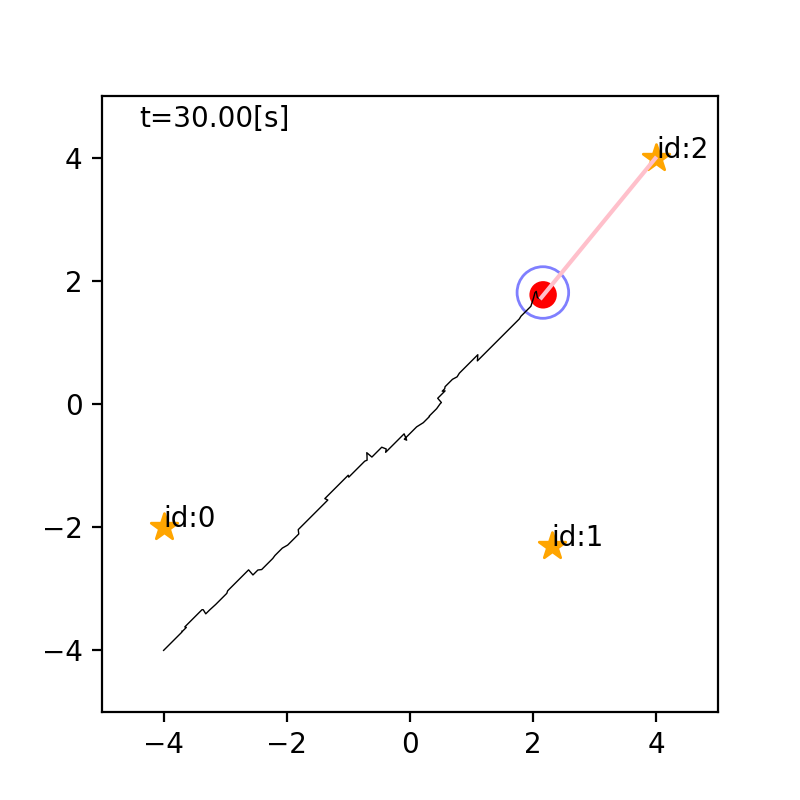

In [17]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    #地図の生成
    m = Map()
    for ln in [(-4.0, -2.0), (2.3, -2.3), (4.0, 4.0)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)
    
    
    #ロボットを作成
    initial_pose = np.array([-4.0, -4.0]).T
    kf = KalmanFilter(m, initial_pose)
    line = EstimationAgent(time_interval, 0.2, 0.2, kf)
    r = Robot(initial_pose, sensor=Camera(m), agent=line, color="red")
    world.append(r)
    world.draw()

trial()